# Example digital stimulation on nidaq in sync with analog input/output


In [1]:
# Create a task
%matplotlib notebook
from labdaq import *

import pylab as plt

pref = default_preferences
task = IOTask(pref['channels'],pref['channel_modes'])


C:\Users\tony\miniconda3\lib\site-packages\ipykernel_launcher.py:26: ResourceWarning: unclosed <socket.socket fd=2360, family=AddressFamily.AF_INET, type=SocketKind.SOCK_DGRAM, proto=0, laddr=('0.0.0.0', 52385)>


<IPython.core.display.Javascript object>


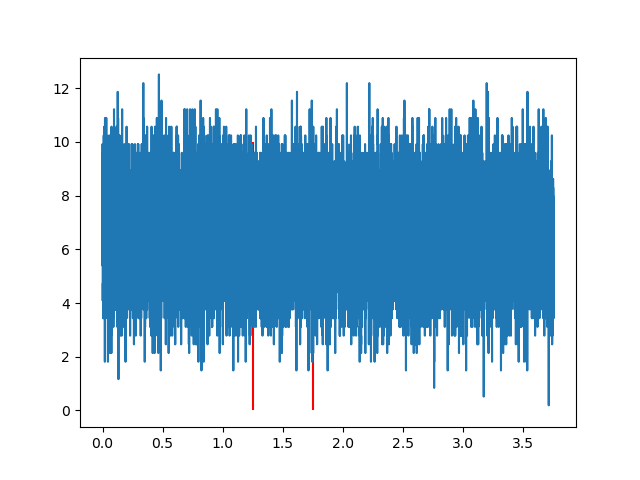

In [3]:
# Connect to labcams, prepare stim (opto and gate)
# opto and gate
blueoff_time = .25
blueon_time = 1 
redon_time = 0.5
ntrials = 10
iti = 1
expname = 'tifftest2'
opto = stimgen_waveform([
    [blueon_time,1,0],
    [blueoff_time,1,0],
    [blueon_time,1,0],
    [redon_time,1,1],
    [blueon_time,1,0,]],
    srate = task.srate)
gate = stimgen_waveform([[blueon_time,1,0],
                         [blueoff_time,1,1],
                         [blueon_time,1,0],
                         [redon_time,1,0],
                         [blueon_time,1,0]],
                        srate = task.srate)

import socket
labcamsaddress = ('widefield.cshl.edu',9999)
udplabcams = socket.socket(socket.AF_INET,
                           socket.SOCK_DGRAM)
# stop labcams
udplabcams.sendto(b'softtrigger=0', labcamsaddress)
# set the experiment name
from datetime import datetime
date = datetime.now().strftime("%Y_%m_%d")
fname = '{0}_{1}_opto_GCaMP'.format(date,expname)
udplabcams.sendto(b'manualsave=0', labcamsaddress)
time.sleep(0.1)
fig = plt.figure()
tstart = 0
for itrial in range(ntrials):
    udplabcams.sendto('expname={0}'.format(fname).encode('utf-8'), labcamsaddress)    
    time.sleep(0.1)
    udplabcams.sendto(b'manualsave=1', labcamsaddress)
    time.sleep(0.1)
    udplabcams.sendto(b'softtrigger=1', labcamsaddress)
    time.sleep(0.1)
    udplabcams.sendto('log=trial:{0}'.format(itrial).encode('utf-8'), labcamsaddress)
    time.sleep(0.1)
    task.load([opto*0],digstim = [opto,gate])
    values = task.run()
    udplabcams.sendto(b'softtrigger=0', labcamsaddress)
    time.sleep(0.1)
    udplabcams.sendto(b'manualsave=0', labcamsaddress)
    
    fig.clf()
    plt.plot(np.arange(len(opto))/task.srate,values.T)
    plt.vlines([blueoff_time+blueon_time,
                blueoff_time+blueon_time+redon_time],0,10,color = 'red')
    
    fig.canvas.draw()
    time.sleep(iti)
    

True